In [1]:
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

fromto = [(12, 15), (1, 6), (17, 21), (5, 11)]

trees = [[1, 5, 3, 1, 3, 5, 8, 8, 5, 12, 12, 12, 5, 15, 15, 12, 5],
         [1, 8, 6, 6, 6, 6, 1, 8, 8, 12, 12, 12, 8, 14, 8, 14, 8],
         [
             2, 2, 2, 5, 5, 2, 9, 8, 9, 2, 11, 9, 14, 14, 9, 17, 17, 14, 17,
             21, 21, 18, 23, 21, 2
         ], [3, 2, 3, 6, 5, 3, 6, 6, 9, 7, 11, 9, 6]]


In [2]:
def get_path(tree, left, right):
    """Get a path from a left token to a right token in a dependency tree.
    """
    # The shortest path from left to right tokens in a depedency tree is only
    # one path or none.
    # The two nodes share a common head; each one may belong to a same branch
    # or different branch. One example could be:
    #     1) left --> node_al --> node_t <-- right
    # the above example shows that the left and right node are under the
    # node_t. Other example is:
    #     2) left --> node_a --> right --> node_t
    # Here, the path should be [left, node_a, right]. Note, that there is no
    # path from right to left nodes.

    # The idea is to traverse through edges from left and right nodes (go to
    # the heas node), at some point the two pathes may intersect at some node
    # (node_t), in the above example. The path would be either the union
    # between two the two pathes till the intersection node (example-1), or the
    # left path till the right node (example-2).

    # The dependency tree is represented in a list of tuples of edges.
    # Say we have an arbitrary tree:
    #       3
    #      / \
    #     8   5
    #    / \
    #   11 20
    # The above tree is represented as:
    #   [(11, 8), (20, 8), (8, 3), (5, 3), (3, 3)]
    # The list of edges above could be unpacked into two lists u, and v.
    # u is the a list of the first element in the edge tuples (list of nodes)
    # and v is the list of the second element (list of heads)

    n_right, n_left = right, left  # right and left nodes
    # right, left pathes (u,v)
    u_right, u_left, v_right, v_left = [], [], [], []
    for _ in range(len(tree)):

        # traverse through edges (left path and right path):
        # add the node and its head to the respective u, v array. The next node
        # will be the head. Stop at the root node (self looping)
        if n_right is not None and tree[n_right] != n_right:
            u_right.append(n_right)
            v_right.append(tree[n_right])
            n_right = v_right[-1]
        else:
            n_right = None

        if n_left is not None and tree[n_left] != n_left:
            u_left.append(n_left)
            v_left.append(tree[n_left])
            n_left = v_left[-1]
        else:
            n_left = None

        # Both right and left nodes are in the sama path.
        if right == n_left:
            U = u_left
            V = v_left
            return U, V

        # Both paths are intersected. Get the union of the intesected pathes.
        elif n_right in v_left:
            if left not in u_right:
                intersect = v_left.index(v_right[-1])
                U = u_left[:intersect + 1] + u_right
                V = v_left[:intersect + 1] + v_right
            else:
                # if the we have path:
                #   a --> ... --> b --> c (intersection)
                # right path (a, b), n_right=c
                # the left path is (b, c)
                # Here there is an intersection at the left path (b c)
                # at c. This is a special case that we do want not to allow. No
                # path from b to a. The right node (a) is found in the left
                # path.
                U, V = [], []

            return U, V

        elif n_left in v_right:
            intersect = v_right.index(v_left[-1])
            U = u_left + u_right[:intersect + 1]
            V = v_left + v_right[:intersect + 1]
            return U, V

    else:
        return [], []


In [3]:
from matplotlib import pyplot as plt
import random


def check_path(tree):
    # Different nodes colors
    color = "lightsteelblue"
    color_path = "rosybrown"
    color_fromto = "lightcoral"

    # pick up randomly two nodes from the tree
    left, right = random.sample(range(len(tree)), k=2)

    # get path from right to left anf from left to right
    for lft, rgt in [[left, right], [right, left]]:

        # convert u, v to a networkx tree object
        G = nx.DiGraph([(u, v) for u, v in enumerate(tree) if u != v])
        G_pos = graphviz_layout(G, prog="dot")

        # get the path then convert it to a tree
        U, V = get_path(tree, lft, rgt)
        Gpath = nx.DiGraph(list(zip(U, V)))
        Gpath_pos = graphviz_layout(Gpath, prog="dot")

        # Draw the original tree and the path sode by side
        fig = plt.figure(figsize=(5.5 * 1.25, 3.5 * 1.25),
                         constrained_layout=True)
        spec = fig.add_gridspec(ncols=2, nrows=1)

        ax2 = fig.add_subplot(spec[0, 1])
        nx.draw(Gpath, Gpath_pos, with_labels=True, ax=ax2)
        n = Gpath.number_of_nodes()
        e = Gpath.number_of_edges()
        ax2.set_title(
            f"Number of Edges: {n}\nNumber of Nodes: {e}\nDifference: {n-e}")

        # Change the color of the nodes of the extracted path
        node_color = []
        for node in G:
            if node in [lft, rgt]:
                node_color.append(color_fromto)
            elif node in Gpath.nodes().keys():
                node_color.append(color_path)
            else:
                node_color.append(color)

        ax1 = fig.add_subplot(spec[0, 0])
        ax1.set_title(f"From: {lft} to {rgt}")
        nx.draw(G,
                G_pos,
                with_labels=True,
                ax=ax1,
                node_color=node_color,
                edgecolors="black")

        for ax in fig.get_axes():
            ax.tick_params(bottom=False,
                           labelbottom=False,
                           left=False,
                           labelleft=False)

        plt.show()



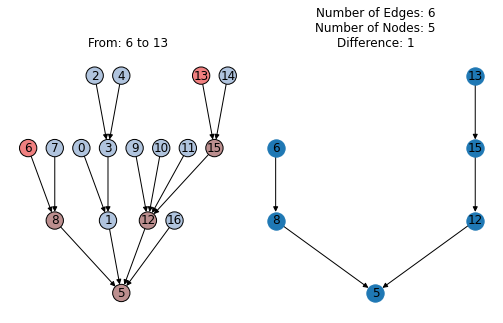

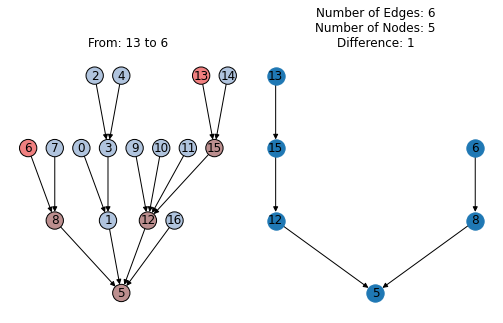

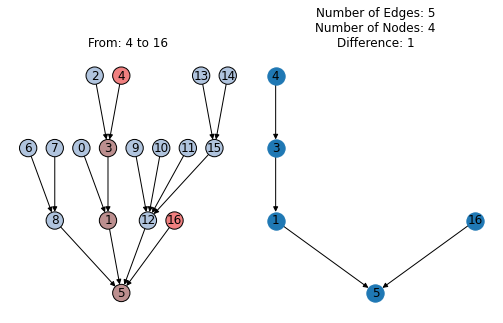

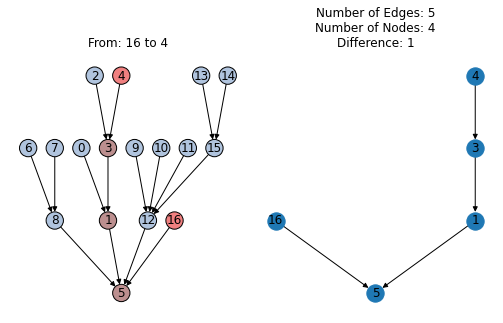

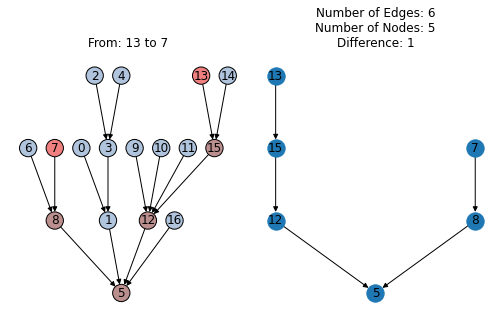

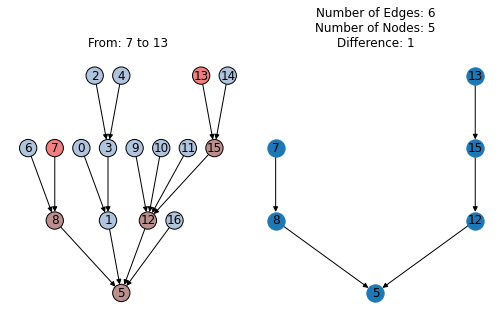

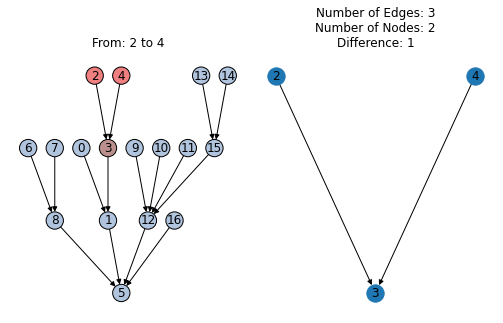

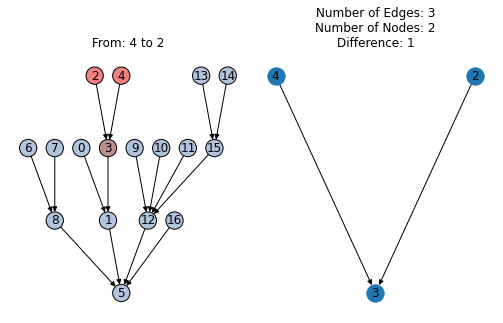

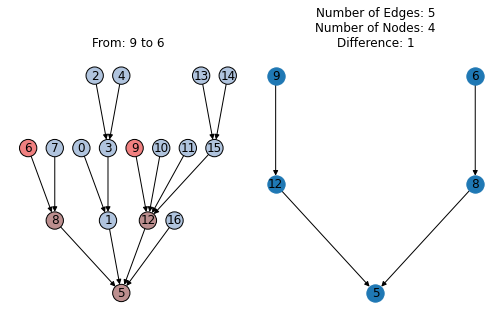

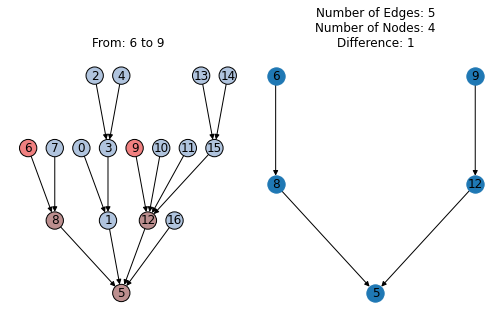

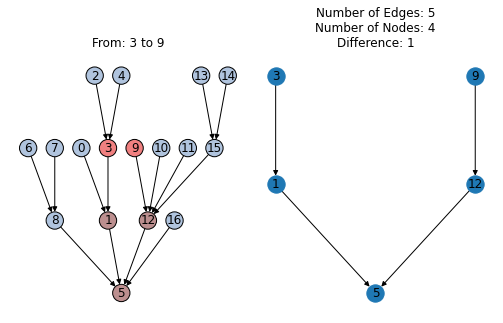

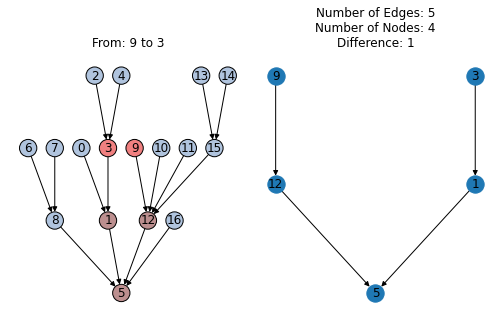

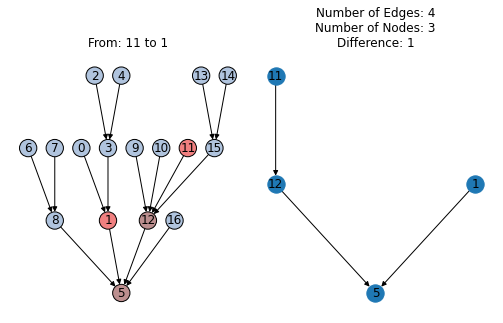

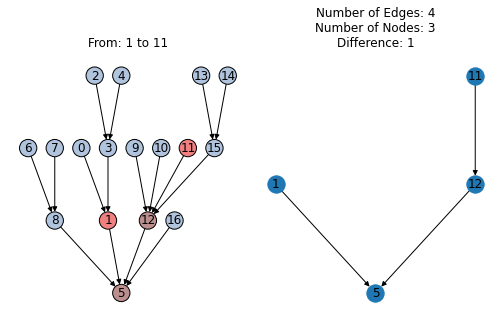

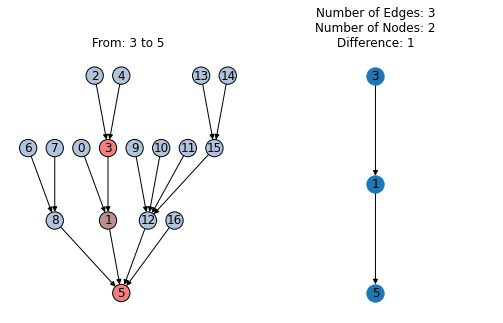

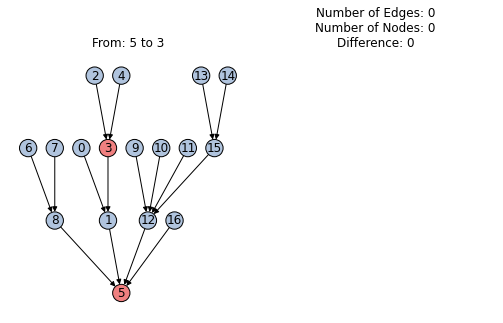

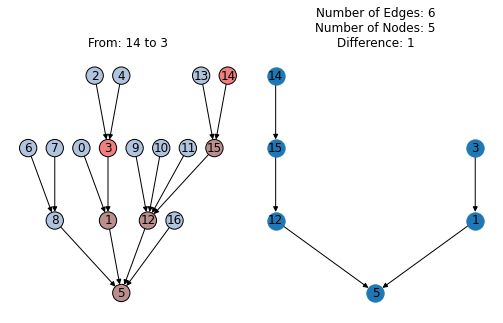

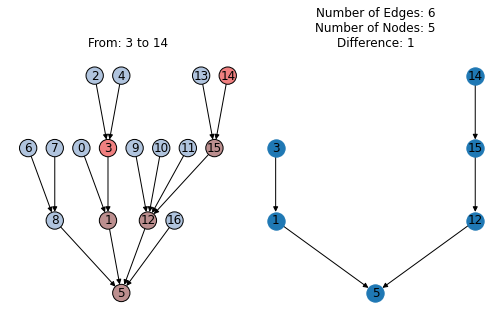

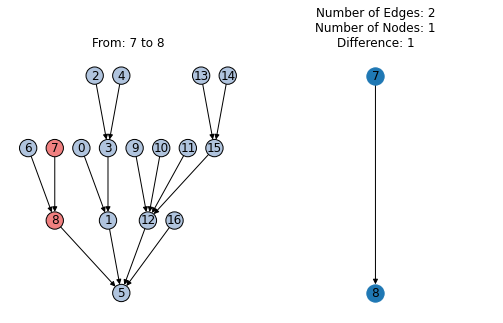

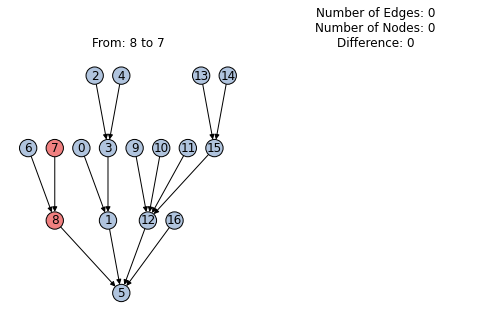

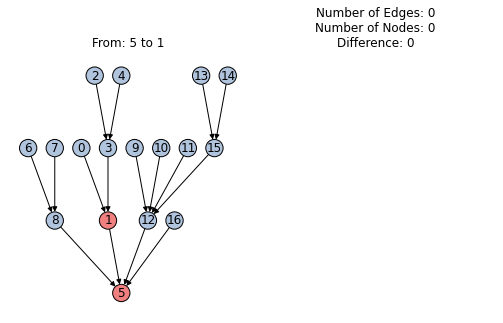

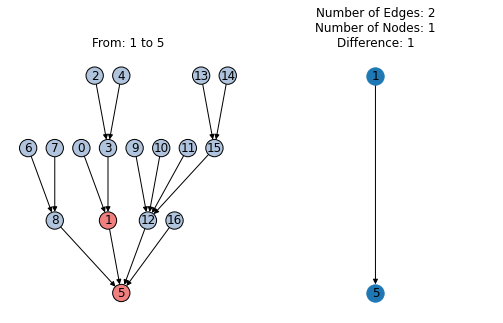

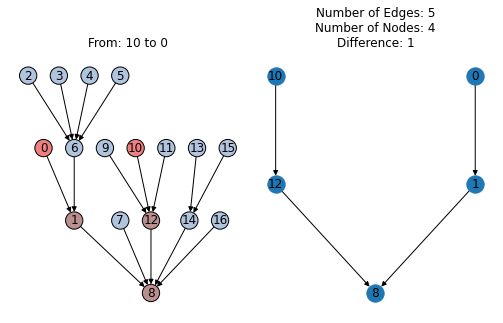

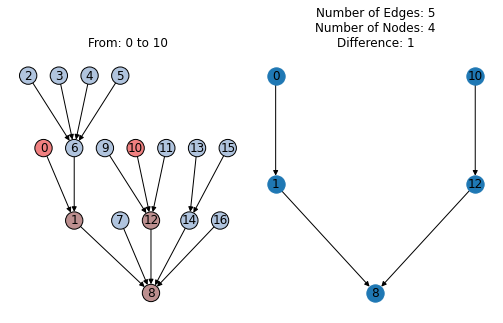

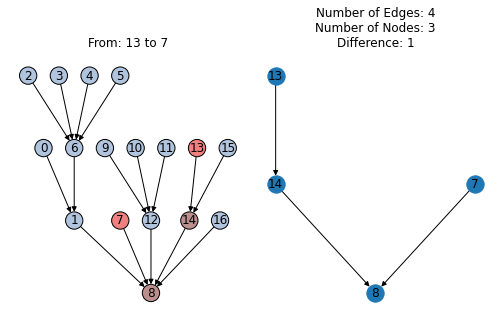

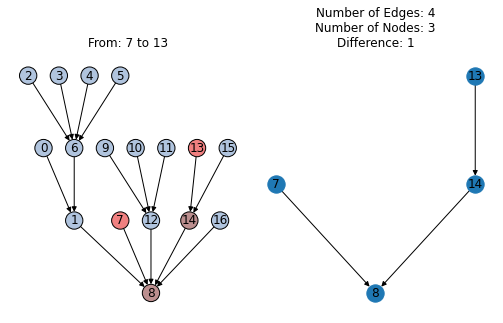

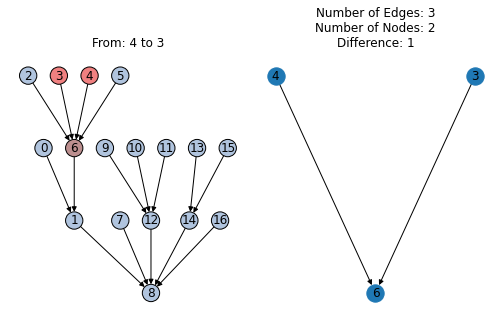

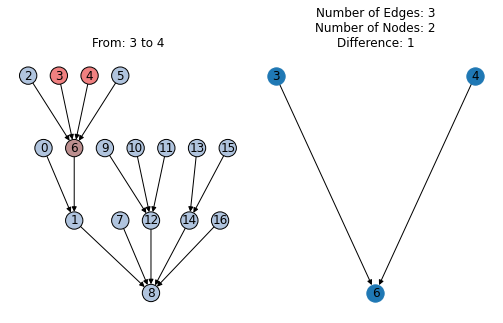

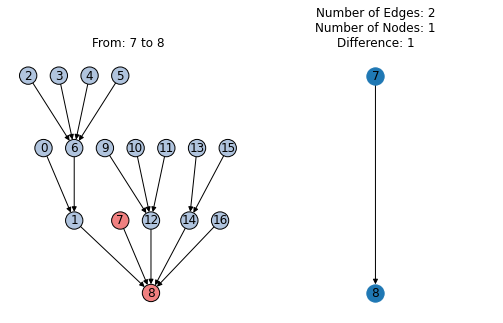

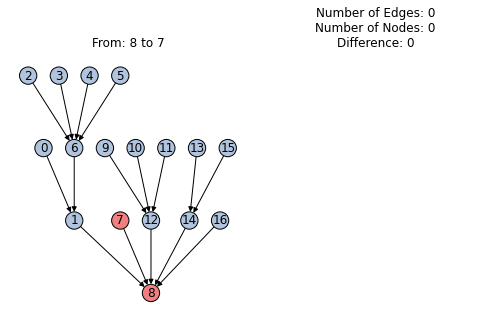

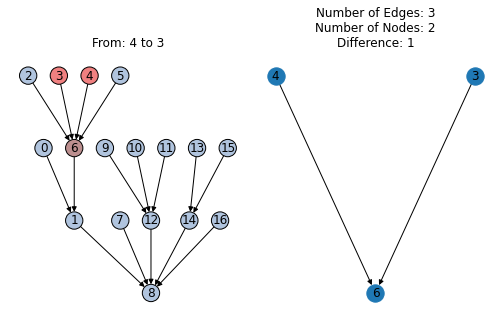

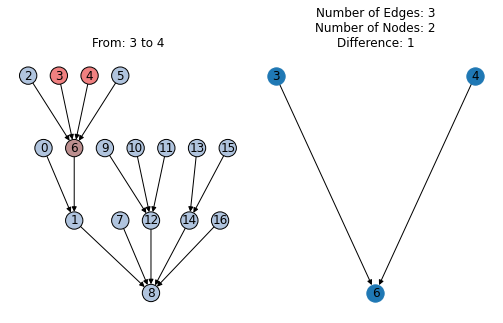

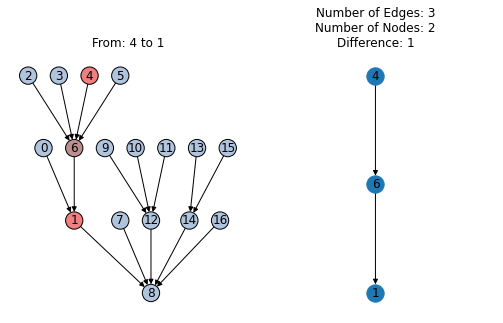

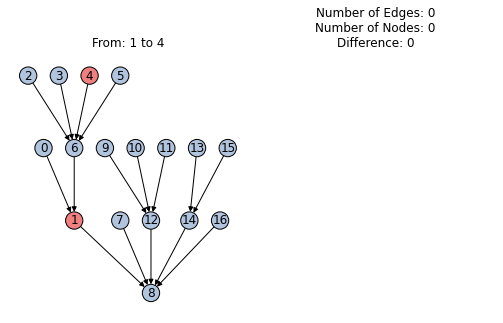

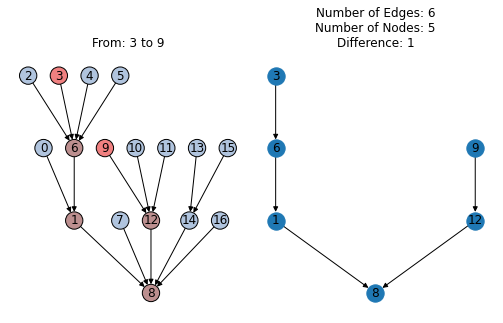

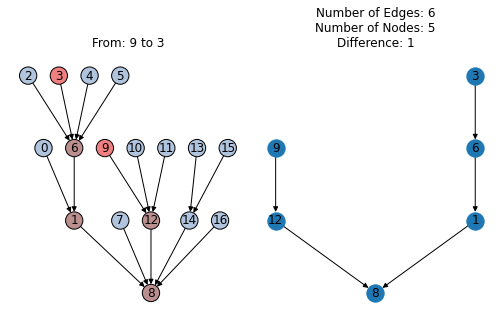

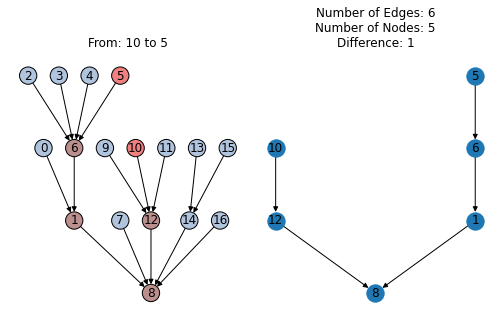

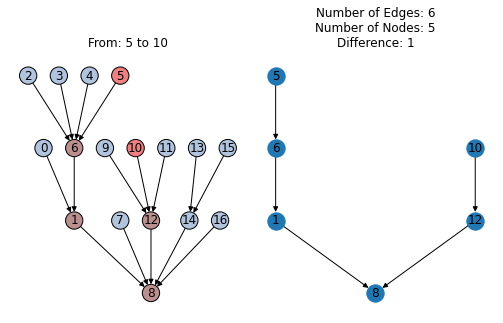

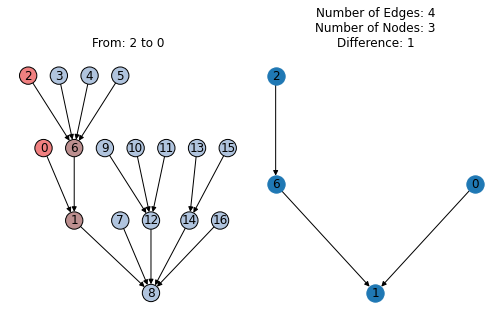

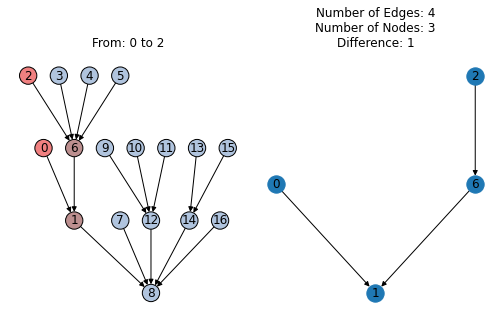

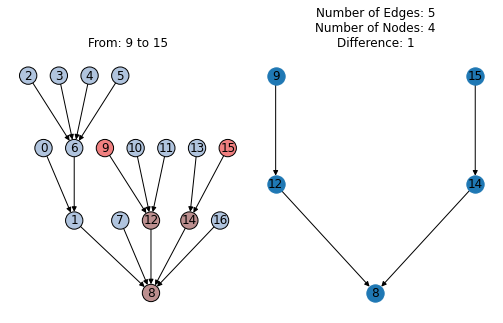

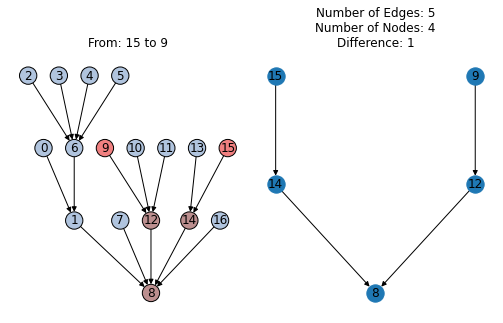

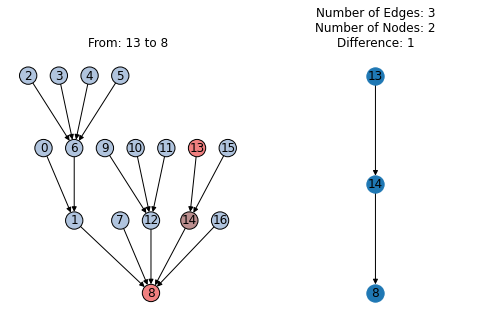

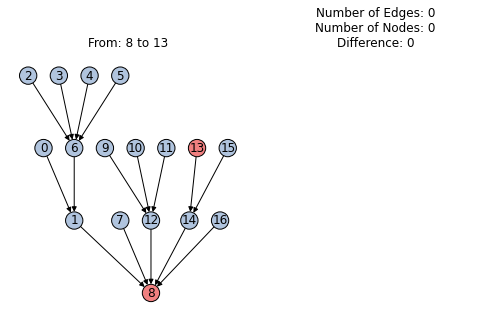

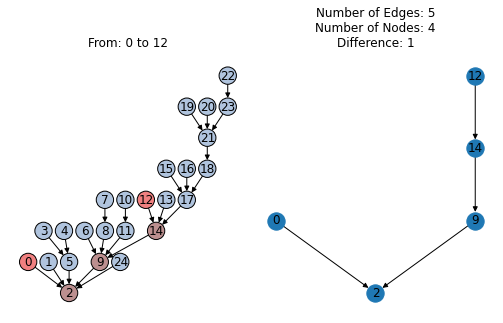

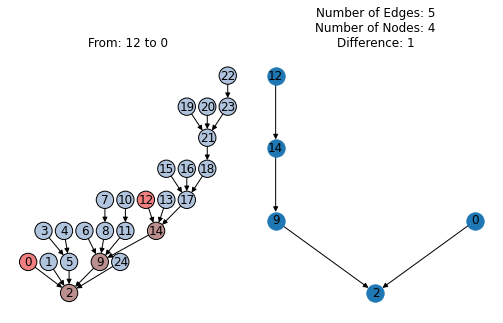

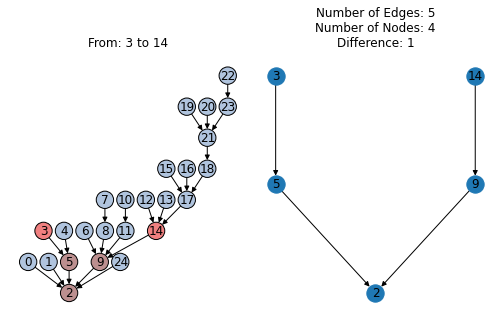

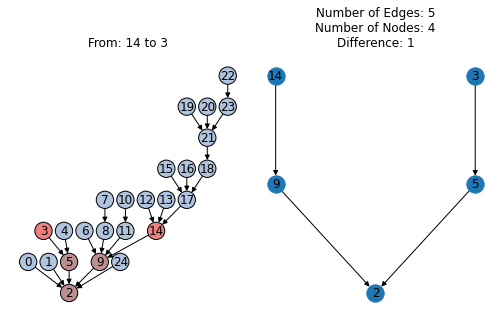

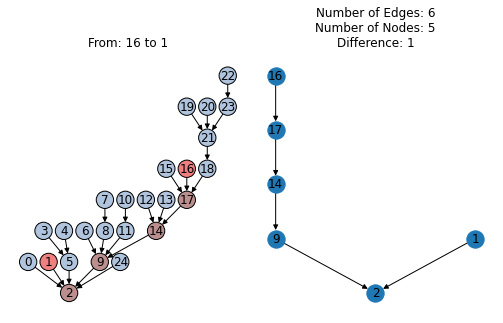

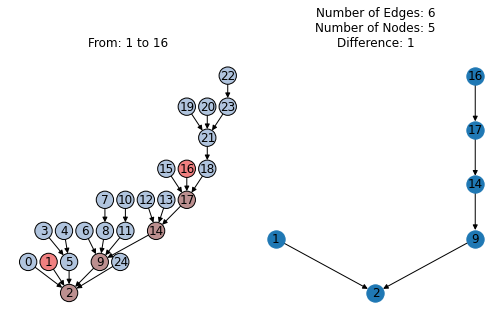

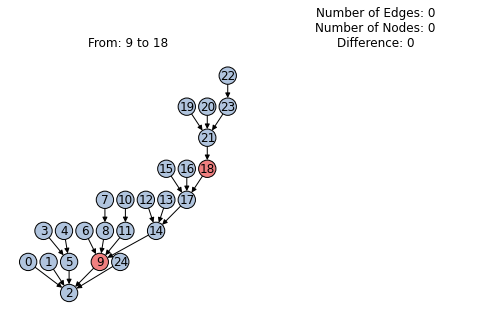

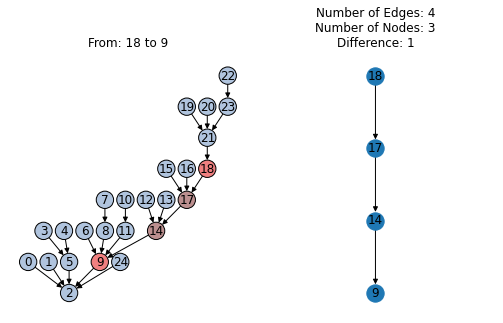

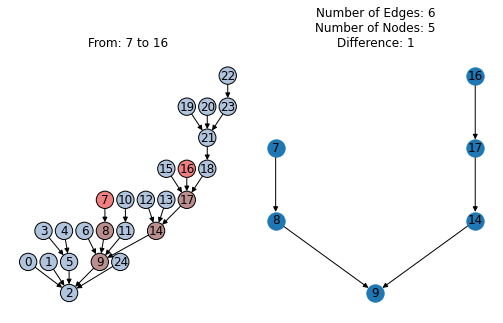

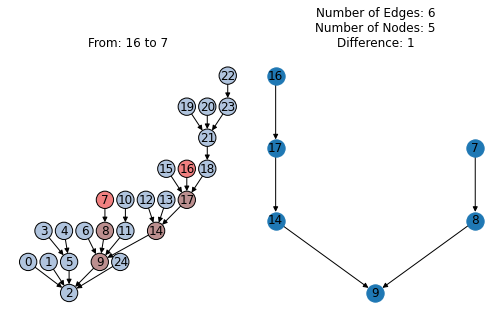

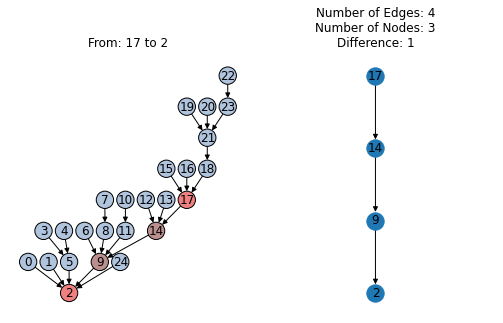

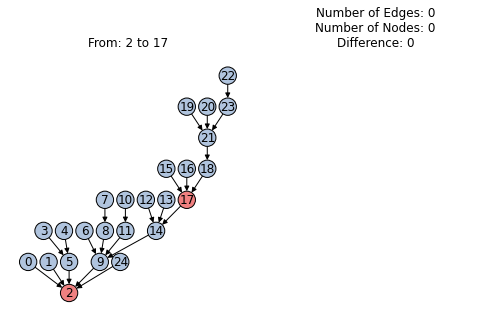

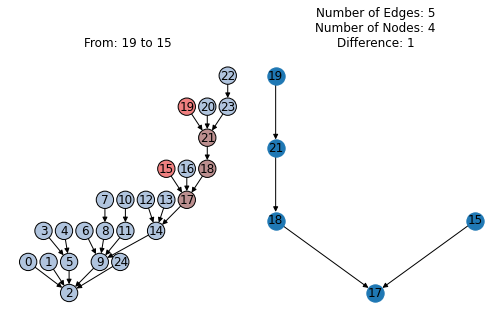

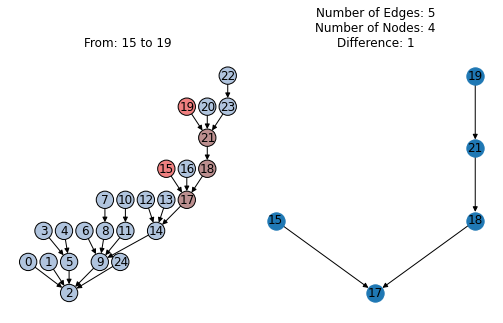

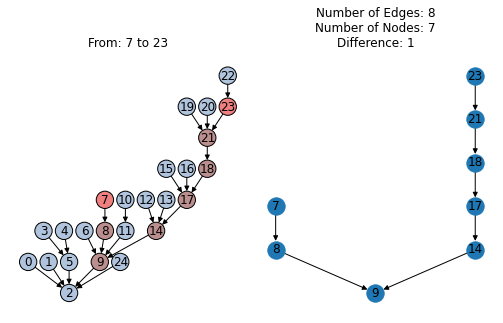

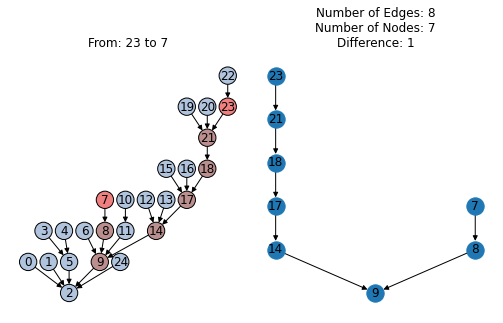

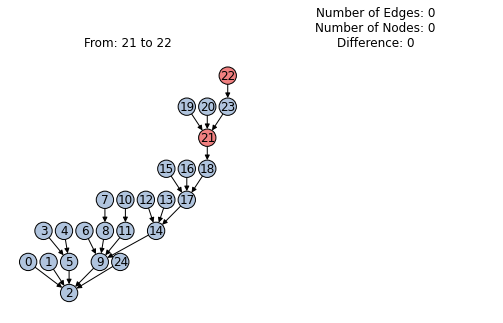

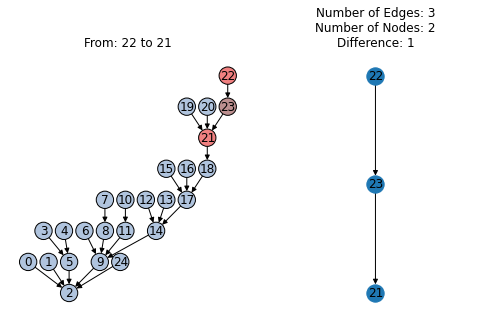

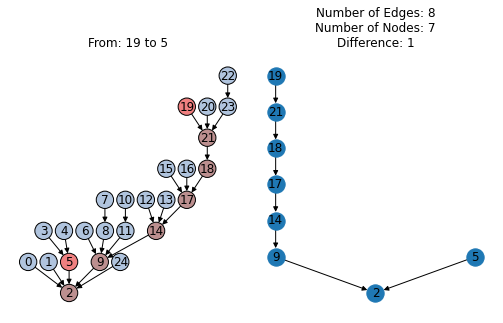

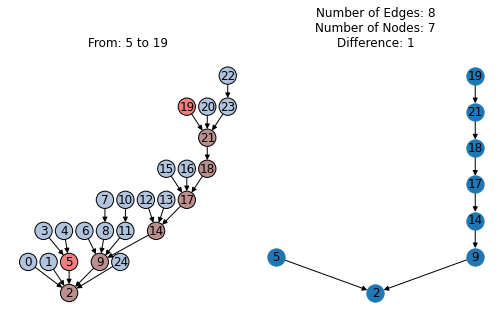

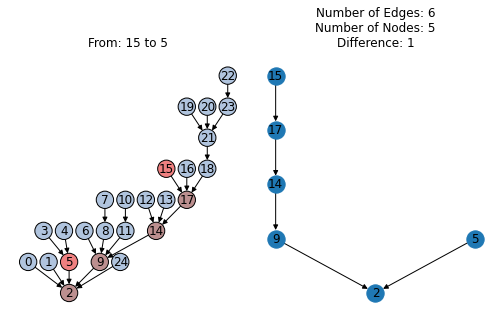

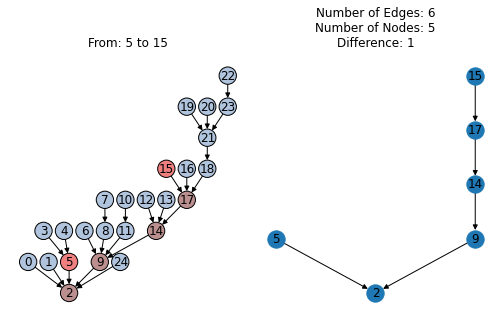

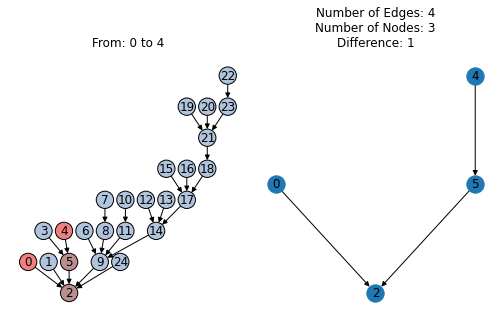

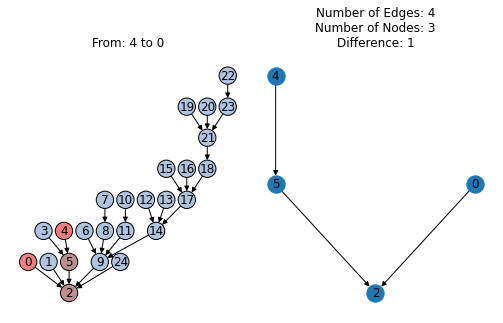

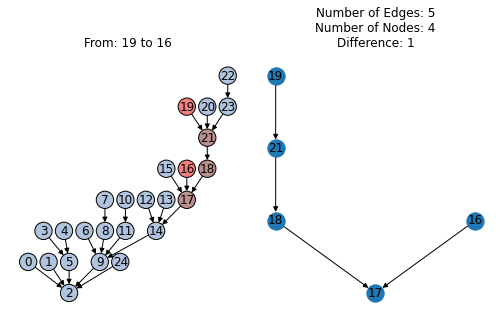

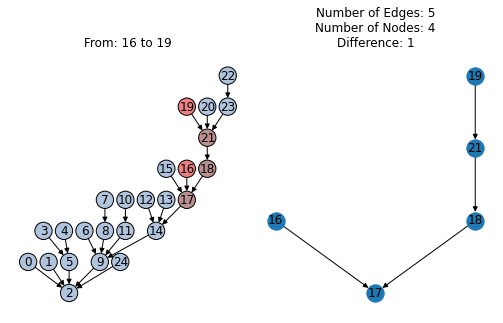

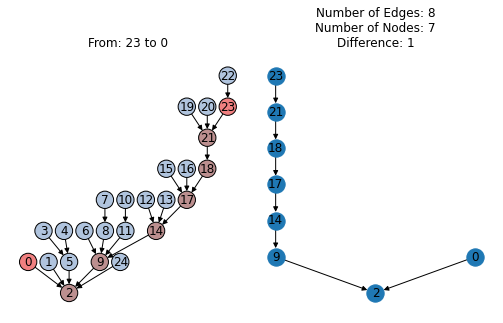

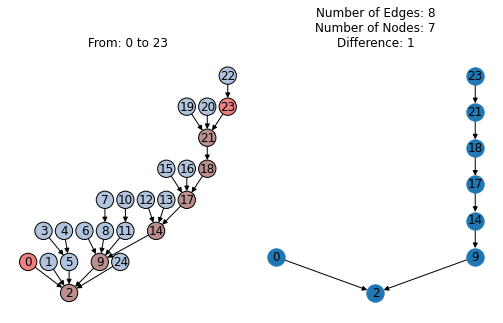

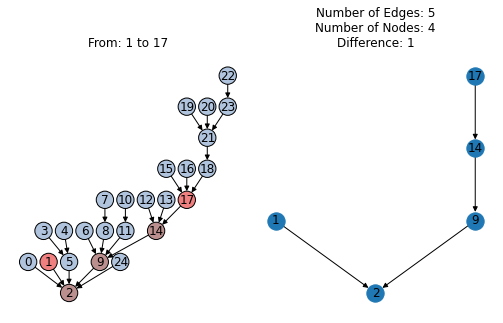

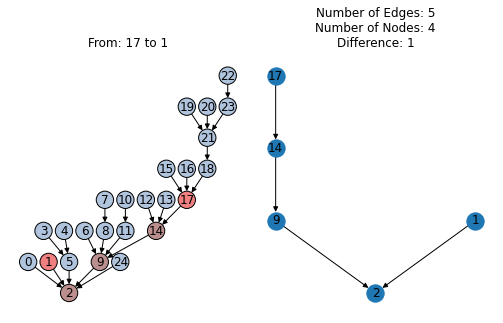

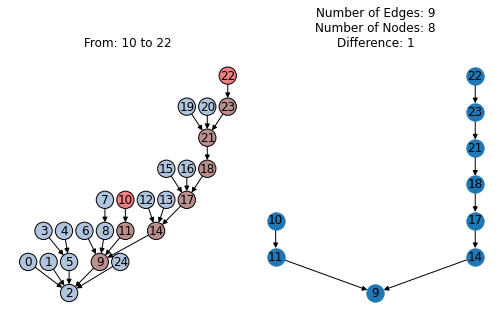

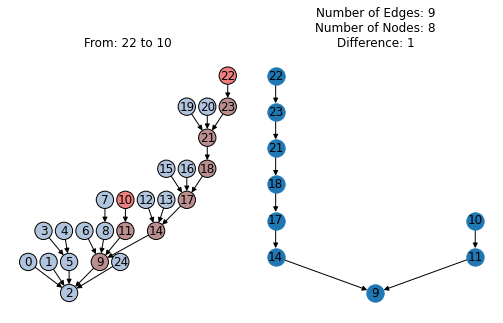

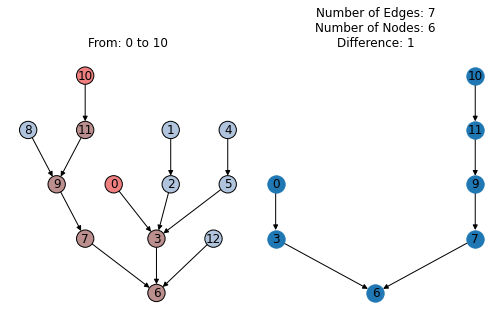

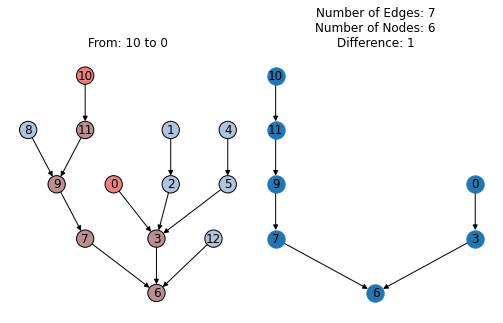

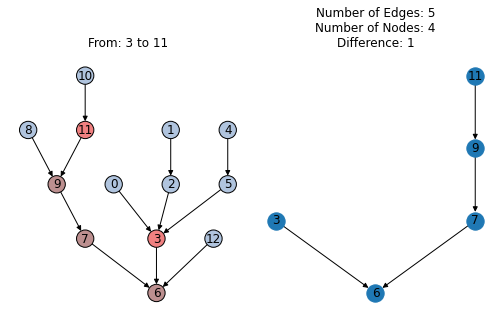

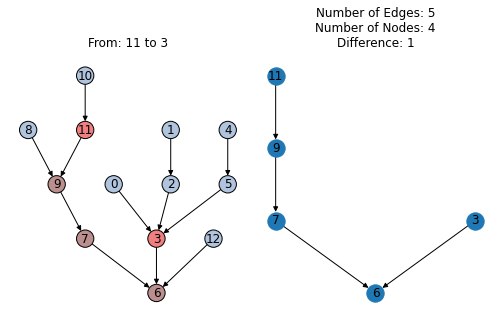

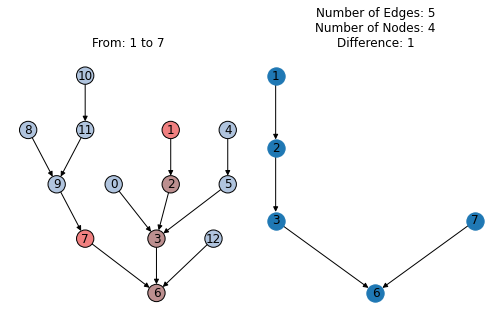

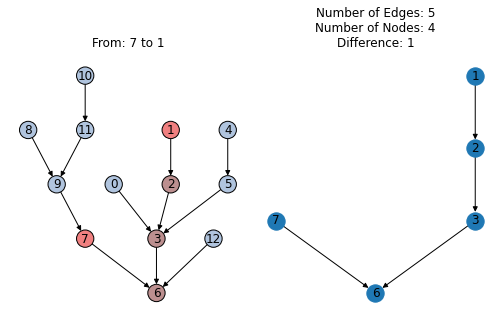

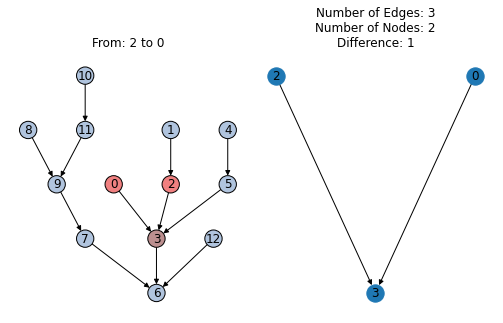

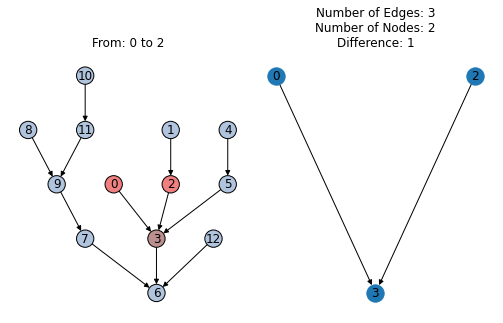

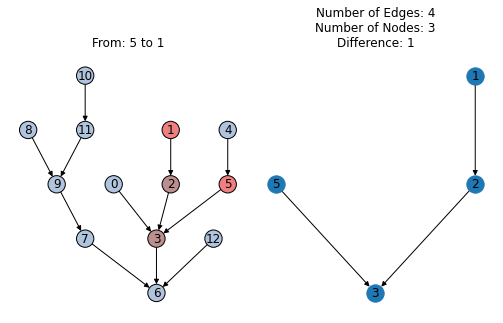

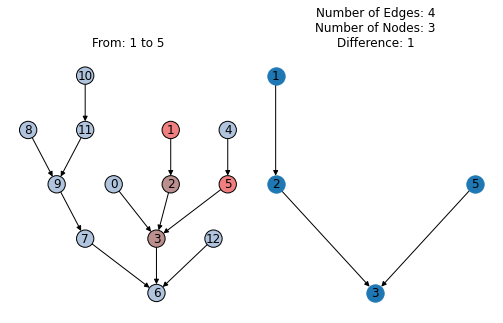

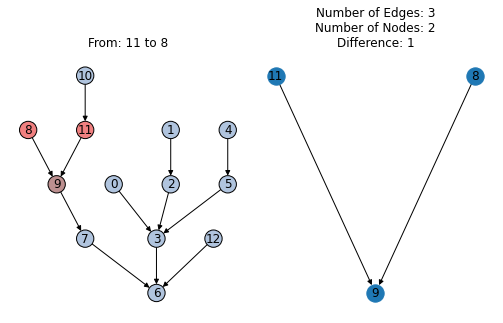

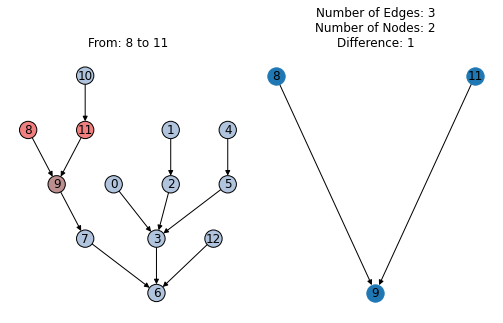

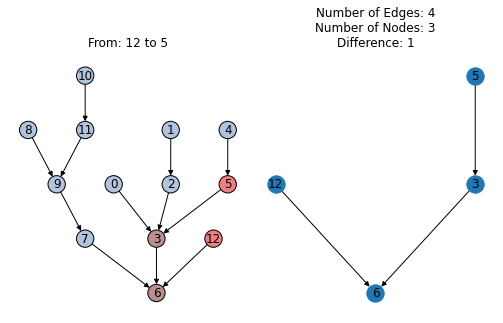

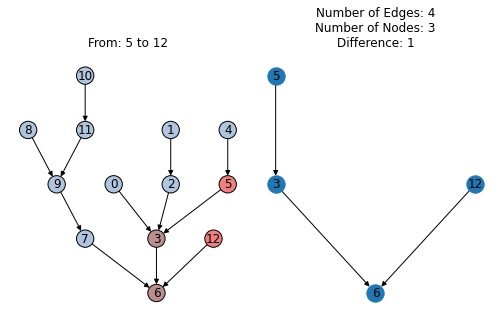

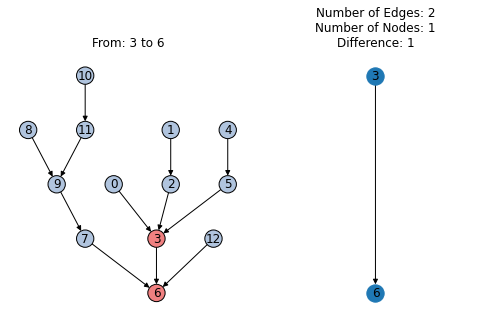

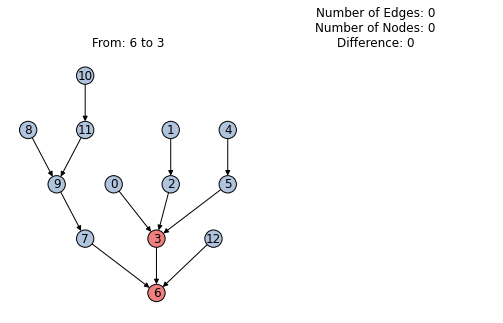

In [4]:
for tree in trees:
    for i in range(2 * len(tree) // 3):
        check_path(tree)
